<a href="https://colab.research.google.com/github/s10nenok/mnist/blob/main/mnistgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import gzip
import torch
import torchvision
import numpy as np
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import random 
import math
import cv2
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

In [57]:
def read_train():
    reorder_type = np.dtype(np.int32).newbyteorder('>')
    way = 'MNIST/raw/'
    tr_im_way = way+'train-images-idx3-ubyte.gz'
    tr_im = gzip.open(tr_im_way,'r')            
    image_magic_number = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    num_images = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    image_rows = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    image_columns = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    buffer = tr_im.read(num_images * image_rows * image_columns)
    images = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
    images = np.reshape(images, (num_images, 28,28))
    images = images/255
    #images = torch.tensor(images)   
    tr_im.close()
 
    tr_lb_way = way+'train-labels-idx1-ubyte.gz'
    tr_lb = gzip.open(tr_lb_way,'r')
    label_magic_number = np.frombuffer(tr_lb.read(4), dtype=reorder_type).astype(np.int64)[0]
    num_labels = np.frombuffer(tr_lb.read(4), dtype=reorder_type).astype(np.int64)[0]
    buffer = tr_lb.read(num_labels)
    labels = np.frombuffer(buffer, dtype = np.uint8)
    #labels = torch.tensor(labels, dtype = torch.long)
    tr_lb.close()

    permutation = np.random.permutation(len(labels)) 
    images = images[permutation] 
    labels = labels[permutation]

    for i in range(len(labels)):    
      images[i] = rotate(images[i])
      images[i] = noise(images[i])
      
    return images,labels

In [58]:
def read_test():
    reorder_type = np.dtype(np.int32).newbyteorder('>')
    way = 'MNIST/raw/'
    tr_im_way = way+'t10k-images-idx3-ubyte.gz'
    tr_im = gzip.open(tr_im_way,'r')            
    image_magic_number = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    num_images = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    image_rows = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    image_columns = np.frombuffer(tr_im.read(4), dtype=reorder_type)[0]
    buffer = tr_im.read(num_images * image_rows * image_columns)
    images = np.frombuffer(buffer, dtype = np.uint8).astype(np.float32)
    images = np.reshape(images, (num_images, 28,28))
    images = images/255
    #images = torch.tensor(images)   
    tr_im.close()
 
    tr_lb_way = way+'t10k-labels-idx1-ubyte.gz'
    tr_lb = gzip.open(tr_lb_way,'r')
    label_magic_number = np.frombuffer(tr_lb.read(4), dtype=reorder_type).astype(np.int64)[0]
    num_labels = np.frombuffer(tr_lb.read(4), dtype=reorder_type).astype(np.int64)[0]
    buffer = tr_lb.read(num_labels)
    labels = np.frombuffer(buffer, dtype = np.uint8)
    #labels = torch.tensor(labels, dtype = torch.long)
    tr_lb.close()

    permutation = np.random.permutation(len(labels)) 
    images = images[permutation] 
    labels = labels[permutation]

    for i in range(len(labels)):    
      images[i] = rotate(images[i])
      images[i] = noise(images[i])
      
    return images,labels

In [59]:
def batch(images,labels,bath_size,i):
    bath_im = np.zeros((bath_size))
    bath_lb = np.zeros((bath_size))
    #bath_im = np.array(images[(i*bath_size):((i+1)*bath_size)])
    bath_im = np.array( [[img] for img in images[(i*bath_size):((i+1)*bath_size)]])
    #print("///////////////////////////")
    #print(bath_im.shape)
    #print(bath_im[0])
    #print("///////////////////////////")
    bath_lb = np.array(labels[(i*bath_size):((i+1)*bath_size)])
    bath_im = torch.Tensor(bath_im)
    bath_lb = torch.tensor(bath_lb)
    return bath_im, bath_lb     


In [60]:
def noise(im):
    noise = np.random.normal(loc = 0.5 , scale = 0.1, size = im.shape)
    imr = np.clip(im + noise, 0, 1)
    return imr

In [61]:
def rotate(im):
    deg = random.randint(0,360)
    h,w = im.shape
    c = 3
    h2,w2,c2 = h//2,w//2,c//2
    np.array([[-w2,w2,w2],[h2,h2,-h2]])
    wr2,hr2 = (np.max(np.abs(rot_mat(deg) @ np.array([[-w2,w2,w2],[h2,h2,-h2]])),axis=1)).astype(np.int32)
    wr,hr = wr2*2,hr2*2
    imr = np.zeros((hr,wr))
    yr,xr = np.indices((hr,wr))
    yr,xr = yr.flatten(),xr.flatten()
    yrc,xrc = yr-hr2,xr-wr2
    xc , yc = (rot_mat(-deg) @ np.row_stack((xrc,yrc))).astype(np.int32)
    x,y = xc+w2,yc+h2
    include = np.logical_and(np.abs(xc)<w2,np.abs(yc)<h2)
    imr[yr[include],xr[include]] = im[y[include],x[include]]
    new_img = cv2.resize(imr, (28, 28) )
    new_img = torch.tensor(new_img)  
    return new_img

def rot_mat(deg):
    theta = deg/180*np.pi
    c,s = np.cos(theta),np.sin(theta)
    return np.array([[c,-s],[s,c]])

In [62]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

 
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [69]:
training_loader =(train_images, train_labels) = read_train()
test_loader =(test_images, test_labels) = read_test()

training_batch_size = 50
test_batch_size = 1000

num_epochs = 10 #25

neural_net = NeuralNet()

train_losses = []
train_counter = []
test_accuracy = []
test_losses= []

test_counter = [num * 60000 for num in range(num_epochs + 1)] 

loss_function = nn.CrossEntropyLoss()

learning_rate = .01
momentum = .9

optimizer = torch.optim.SGD(neural_net.parameters(), lr = learning_rate, momentum = momentum)

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [64]:
def train(epoch):
     for batch_idx in range(60000//training_batch_size): 
        images,labels = batch(train_images,train_labels,training_batch_size,batch_idx)

       # print(images.shape)
        #print(len(images))
        #print(images)

        optimizer.zero_grad()

        output = neural_net(images)

        loss = F.nll_loss(output, labels)

        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * training_batch_size, 60000,
                    100 * batch_idx / len(training_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx * training_batch_size) + ((epoch - 1) * 60000)) 

In [65]:
def test():
    test_loss = 0
    correct_guesses = 0
    with torch.no_grad():
        for batch_idx in range(10000//test_batch_size): 
            images,labels = batch(test_images,test_labels,test_batch_size,batch_idx)

            output = neural_net(images)
            
            test_loss += F.nll_loss(output, labels).item()
            
            guesses = torch.max(output, 1, keepdim = True)[1]

            correct_guesses += torch.eq(guesses, labels.data.view_as(guesses)).sum()

        test_loss /= float(10000)/test_batch_size
        test_losses.append(test_loss)

        current_accuracy = float(correct_guesses)/float(10000)
        test_accuracy.append(current_accuracy)

        print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct_guesses,10000,
                100. * current_accuracy)) 

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329890
Train Epoch: 1 [5000/60000 (5000%)]	Loss: 2.274763
Train Epoch: 1 [10000/60000 (10000%)]	Loss: 2.237975
Train Epoch: 1 [15000/60000 (15000%)]	Loss: 2.159330
Train Epoch: 1 [20000/60000 (20000%)]	Loss: 2.120431
Train Epoch: 1 [25000/60000 (25000%)]	Loss: 1.833173
Train Epoch: 1 [30000/60000 (30000%)]	Loss: 1.721266
Train Epoch: 1 [35000/60000 (35000%)]	Loss: 1.705320
Train Epoch: 1 [40000/60000 (40000%)]	Loss: 1.712985
Train Epoch: 1 [45000/60000 (45000%)]	Loss: 1.612246
Train Epoch: 1 [50000/60000 (50000%)]	Loss: 1.607323
Train Epoch: 1 [55000/60000 (55000%)]	Loss: 1.474936

Test set: Avg. loss: 1.5126, Accuracy: 4593/10000 (46%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.604546
Train Epoch: 2 [5000/60000 (5000%)]	Loss: 1.436457
Train Epoch: 2 [10000/60000 (10000%)]	Loss: 1.243573
Train Epoch: 2 [15000/60000 (15000%)]	Loss: 1.732362
Train Epoch: 2 [20000/60000 (20000%)]	Loss: 1.262112
Train Epoch: 2 [25000/60000 (25000%)]	Loss: 1.254059
Train Ep

ValueError: ignored

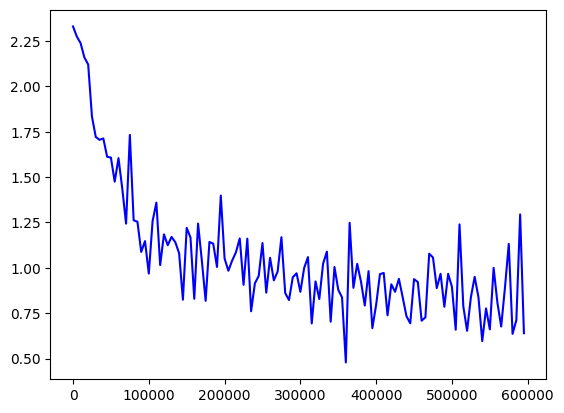

In [70]:
if __name__ == "__main__":
    for epoch in range(1, num_epochs + 1):
        train(epoch)
        test()
    #test()

    print('Total epochs: {}'.format(num_epochs))
    print('Max Accuracy is: {}%'.format(round(100*max(test_accuracy), 2)))

    fig = plt.figure()
    plt.plot(train_counter, train_losses, color = 'blue', zorder = 1)
    plt.scatter(test_counter, test_losses, color = 'red', zorder = 2)
    plt.scatter(test_counter, test_accuracy, color = 'green', marker = '+', zorder = 3)
    plt.legend(['Train Loss', 'Test Loss', 'Accuracy'], loc = 'upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig